# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [240]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [241]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [242]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [243]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [244]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [245]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [246]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [247]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [248]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [249]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [250]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [251]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [252]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [253]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

# sent_1000 = final['Text'].values[1000]
# print(sent_1000)
# print("="*50)

# sent_1500 = final['Text'].values[1500]
# print(sent_1500)
# print("="*50)

# sent_4900 = final['Text'].values[4900]
# print(sent_4900)
# print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [254]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
# sent_1000 = re.sub(r"http\S+", "", sent_1000)
# sent_150 = re.sub(r"http\S+", "", sent_1500)
# sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [255]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

# soup = BeautifulSoup(sent_1000, 'lxml')
# text = soup.get_text()
# print(text)
# print("="*50)

# soup = BeautifulSoup(sent_1500, 'lxml')
# text = soup.get_text()
# print(text)
# print("="*50)

# soup = BeautifulSoup(sent_4900, 'lxml')
# text = soup.get_text()
# print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [256]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [257]:
# sent_1500 = decontracted(sent_1500)
# print(sent_1500)
# print("="*50)

In [258]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [259]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
# sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
# print(sent_1500)

In [260]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [261]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [00:41<00:00, 2126.88it/s]


In [262]:
# preprocessed_reviews[1500]

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [263]:
## Similartly you can do preprocessing for review summary also.

In [264]:
from sklearn.model_selection import train_test_split

print(type(final['Text']))
final['Text'] = preprocessed_reviews

X = final['Text'].values
Y = final['Score'].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3) 

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

<class 'pandas.core.series.Series'>
(61441,) (61441,)
(26332,) (26332,)


# [4] Featurization

## [4.1] BAG OF WORDS

In [265]:
#BoW
from scipy.sparse import hstack

count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(X_train)
# print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

X_train_bow = count_vect.transform(X_train)
X_test_bow = count_vect.transform(X_test)

print("the type of count vectorizer ",type(X_train_bow))
print("the shape of out text BOW vectorizer ",X_train_bow.get_shape())
print("the number of unique words ", X_train_bow.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (61441, 46442)
the number of unique words  46442


## [4.3] TF-IDF

In [266]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

X_train_tfidf = tf_idf_vect.transform(X_train)
X_test_tfidf = tf_idf_vect.transform(X_test)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of TFIDF vectorizer ",type(X_train_tfidf))
print("the shape of out text TFIDF vectorizer ",X_train_tfidf.get_shape())
print("the number of unique words including both unigrams and bigrams ", X_train_tfidf.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'abandoned', 'abdominal', 'ability', 'able', 'able add', 'able buy', 'able chew', 'able drink', 'able eat']
the type of TFIDF vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (61441, 36359)
the number of unique words including both unigrams and bigrams  36359


## [4.4] Word2Vec

In [267]:
# Train your own Word2Vec model using your own text corpus 
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())

w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=2)

In [268]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  14813
sample words  ['really', 'like', 'wild', 'ride', 'jerky', 'good', 'bang', 'buck', 'bbq', 'not', 'would', 'recommend', 'even', 'trying', 'tastes', 'dried', 'sauce', 'always', 'liked', 'chocolate', 'covered', 'almonds', 'something', 'combination', 'enjoyable', 'got', 'chance', 'try', 'jumped', 'right', 'away', 'first', 'container', 'much', 'bigger', 'thought', 'lot', 'nuts', 'one', 'package', 'secondly', 'unlike', 'baked', 'dipped', 'dramatically', 'cuts', 'mess', 'flavor', 'normally', 'big']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [269]:
# average Word2Vec
# compute average word2vec for each review.
def avgw2v(list_of_sentance):
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_sentance): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    return sent_vectors

In [270]:
sent_vectors_train = avgw2v(list_of_sentance_train)
print(len(sent_vectors_train[0]))
print(len(list_of_sentance_train))

100%|███████████████████████████████████████████████████████████████████████████| 61441/61441 [02:11<00:00, 466.95it/s]


50
61441


In [271]:
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

sent_vectors_test = avgw2v(list_of_sentance_test)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|███████████████████████████████████████████████████████████████████████████| 26332/26332 [00:56<00:00, 468.48it/s]


26332
50


#### [4.4.1.2] TFIDF weighted W2v

In [272]:
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

In [273]:
# TF-IDF weighted Word2Vec
def tfidfw2v(list_of_sentance):
    tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
    # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(list_of_sentance): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
    #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
    return tfidf_sent_vectors

In [274]:
tfidf_sent_vectors_train = tfidfw2v(list_of_sentance_train)

100%|████████████████████████████████████████████████████████████████████████████| 61441/61441 [33:34<00:00, 30.50it/s]


In [275]:
tfidf_sent_vectors_test = tfidfw2v(list_of_sentance_test)

100%|████████████████████████████████████████████████████████████████████████████| 26332/26332 [13:29<00:00, 32.52it/s]


# Applying Logistic Regression

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

In [276]:
%config IPCompleter.greedy=True
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler

In [277]:
# Function to find the best optimal Lamda using LogisticRegression and GridSearchCV
def getOptimizedLamda(X_train_vector, Y_train, regularization):
    lamda_vals = np.logspace(-3, 3, 5) # 10^-3 to 10^3 and no. of samples =5

    param_grid = dict(C=lamda_vals)
    clf = LogisticRegression(penalty = regularization)

    grid = GridSearchCV(clf, param_grid, cv=10, scoring='roc_auc')  # 10 fold cross validation
    grid.fit(X_train_vector, Y_train)

    print("Best Estimator: ",grid.best_estimator_)
#     print("Best Estimator Coef/Weight: ",grid.best_estimator_.coef_)
    print("Best cross-validation score: {:.2f}".format(grid.best_score_))  # best score of cross validation
    best_lamda = round(grid.best_params_['C'],3)  # best lamda value after 10 fold cross validation, here C = 1/lamda
    print("Best parameters: ", best_lamda)

    train_auc= grid.cv_results_['mean_train_score']
    cv_auc = grid.cv_results_['mean_test_score'] 

    plt.plot(lamda_vals, train_auc, label='Train AUC')
    plt.plot(lamda_vals, cv_auc, label='CV AUC')

    plt.legend()
    plt.xlabel("Lamda: hyperparameter")
    plt.ylabel("AUC")
    plt.title("ERROR PLOTS")
    plt.show()
    return best_lamda, grid.best_estimator_.coef_

Best Estimator:  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Best cross-validation score: 0.93
Best parameters:  1.0


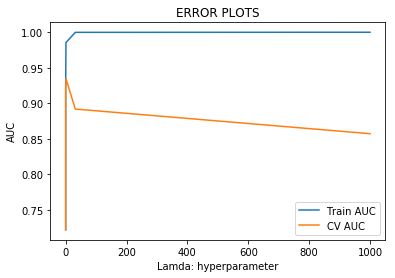

In [278]:
bestLamda_bow_l1, weight_bow_l1 = getOptimizedLamda(X_train_bow, Y_train, regularization='l1')

In [279]:
# Applying the model on test data with optimal value of C and find the AUC for LogisticRegression
def LR_test(X_train_vector, Y_train, X_test_vector, Y_test, best_lamda, regularization):
    clf = LogisticRegression(penalty = regularization, C=best_lamda)
    clf.fit(X_train_vector, Y_train)

    train_fpr, train_tpr, threshold = roc_curve(Y_train, clf.predict_log_proba(X_train_vector)[:,1])
    test_fpr, test_tpr, threshold = roc_curve(Y_test, clf.predict_log_proba(X_test_vector)[:,1])

    test_auc = auc(test_fpr, test_tpr)
    plt.plot(train_fpr, train_tpr, label = "Train AUC:"+str(auc(train_fpr,train_tpr)))
    plt.plot(test_fpr, test_tpr, label = "Test AUC:"+str(test_auc))

    plt.legend()
    plt.xlabel("Lamda -> Hyperparameter")
    plt.ylabel("AUC")
    plt.title("Error Plot")
    plt.show()

    print("training confusion matrix")
    print(confusion_matrix(Y_train, clf.predict(X_train_vector)))
    test_cm = confusion_matrix(Y_test, clf.predict(X_test_vector))

    # plot confusion matrix to describe the performance of classifier.
    class_label = ["negative", "positive"]
    df_cm = pd.DataFrame(test_cm, index = class_label, columns = class_label)
    sns.heatmap(df_cm, annot = True, fmt = "d")
    plt.title("Confusion Matrix of Test data")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    
    return test_auc, clf

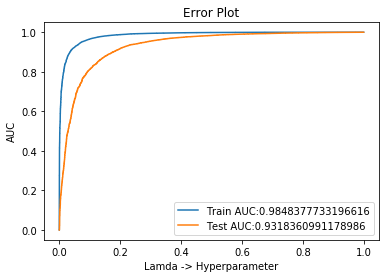

training confusion matrix
[[ 8022  1917]
 [  663 50839]]


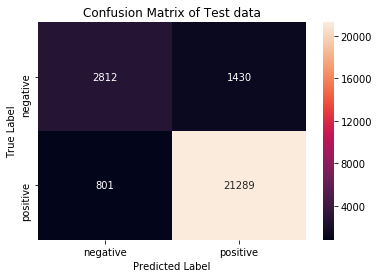

In [280]:
auc_bow_l1, classifier_bow_l1 = LR_test(X_train_bow, Y_train, X_test_bow, Y_test, bestLamda_bow_l1, regularization = 'l1')

#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [281]:
for i in [0.001,0.1,1,10,100,1000]:
    clf = LogisticRegression(C= i, penalty= 'l1')
    clf.fit(X_train_bow,Y_train)
    print("For C =",i)
    print("Non Zero weights:",np.count_nonzero(clf.coef_))
    print("---------------")

For C = 0.001
Non Zero weights: 5
---------------
For C = 0.1
Non Zero weights: 912
---------------
For C = 1
Non Zero weights: 4669
---------------
For C = 10
Non Zero weights: 9580
---------------
For C = 100
Non Zero weights: 11244
---------------
For C = 1000
Non Zero weights: 17160
---------------


### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

Best Estimator:  LogisticRegression(C=0.03162277660168379, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Best cross-validation score: 0.94
Best parameters:  0.032


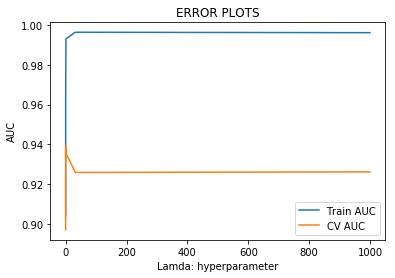

In [282]:
bestLamda_bow_l2, weight_bow_l2 = getOptimizedLamda(X_train_bow, Y_train, regularization='l2')

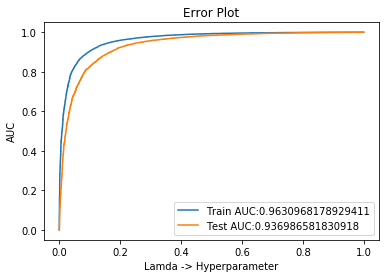

training confusion matrix
[[ 6225  3714]
 [  741 50761]]


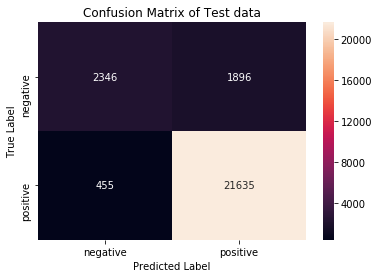

In [283]:
auc_bow_l2, classifier_bow_l2 = LR_test(X_train_bow, Y_train, X_test_bow, Y_test, bestLamda_bow_l2, regularization = 'l2')

#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [284]:
import copy
from scipy.sparse import csr_matrix

# Get the weights W after fit your model with the data X i.e Train data.
weights_org = weight_bow_l1  #weight vector of best estimator of original classifier using l1

X_train_bow_pert = copy.deepcopy(X_train_bow)   # copy X_train_bow to X_train_bow_pert to add error into it

e = 0.02  
X_train_bow_pert = csr_matrix(X_train_bow_pert,dtype=np.float64) # Convert dbtype int to float to add float value else give error

# Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse matrix, X.data+=e)
#adding a nonzero scalar to a sparse matrix is not supported so we add only to nonzero values
X_train_bow_pert[np.nonzero(X_train_bow_pert)] += e   # adding small error in training data

# Fit the model again on data X' and get the weights W'
clf_pert = LogisticRegression(penalty = 'l1', C=bestLamda_bow_l1)
clf_pert.fit(X_train_bow_pert, Y_train)
weight_pert = clf_pert.coef_

# Now find the % change between W and W' (| (W-W') / (W) |)*100)
weights_diff_percentage=abs((weights_org-weight_pert)/weights_org)*100

In [309]:
# Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of 
# percentage_change_vector
print(np.nanpercentile(weights_diff_percentage, 10))
print(np.nanpercentile(weights_diff_percentage, 20))
print(np.nanpercentile(weights_diff_percentage, 30))
print(np.nanpercentile(weights_diff_percentage, 40))
print(np.nanpercentile(weights_diff_percentage, 50))
print(np.nanpercentile(weights_diff_percentage, 60))
print(np.nanpercentile(weights_diff_percentage, 70))
print(np.nanpercentile(weights_diff_percentage, 80))
print(np.nanpercentile(weights_diff_percentage, 90))
print(np.nanpercentile(weights_diff_percentage, 99))
print('='*20)
print(np.nanpercentile(weights_diff_percentage, 98.1))
print(np.nanpercentile(weights_diff_percentage, 98.2))
print(np.nanpercentile(weights_diff_percentage, 98.3))
print(np.nanpercentile(weights_diff_percentage, 98.4))
print(np.nanpercentile(weights_diff_percentage, 98.5))
print(np.nanpercentile(weights_diff_percentage, 98.6))
print(np.nanpercentile(weights_diff_percentage, 98.7))
print(np.nanpercentile(weights_diff_percentage, 98.8))
print(np.nanpercentile(weights_diff_percentage, 98.9))
print(np.nanpercentile(weights_diff_percentage, 99))

0.3317105004167928
0.6414854778682685
0.9522476030388332
1.2648297332738812
1.5491929323216613
1.9654091820151085
2.795449300490577
5.064035572969312
13.951757079274428
inf
217.24733794619414
336.5712756741769
524.9039724576016
700.0535329519273
inf
inf
inf
inf
inf
inf


### As per above analysis we can set 98.6 as threshold above which the weights are increased drastically.

In [310]:
# Print the features whose % change is more than a threshold x
features = count_vect.get_feature_names()
print("No of features having weight changes greater than 98.1%: ", weights_diff_percentage[np.where(weights_diff_percentage > 98.1)].size)
collinear_features=[]
print("\nBelow features are collinear:")
for i in np.where(weights_diff_percentage > 98.1)[1]:
    collinear_features.append(features[i])
print(collinear_features[:10])

No of features having weight changes greater than 98.1%:  131

Below features are collinear:
['addictively', 'afghanistan', 'appeal', 'arnt', 'average', 'avoids', 'badoit', 'bellies', 'bike', 'blenders']


### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [287]:
# Positive important features
def positive_imp_features(model,classifier):
    vocabulary = model.get_feature_names()
    words = list(classifier.coef_[0])
    pos_coef = []    
    pos_words = []    
    for index,coef in enumerate(words):
        if coef > 0:
            pos_coef.append(coef)
            pos_words.append(vocabulary[index])        
    pos_df = pd.DataFrame(columns = ['Words','Coef'])    
    pos_df['Words'] = pos_words
    pos_df['Coef'] = pos_coef   
    pos_df = pos_df.sort_values("Coef",axis = 0,ascending = False).reset_index(drop=True)     
    print("Top ten positive features:\n",pos_df.head(10))

In [288]:
positive_imp_features(count_vect,classifier_bow_l1)

Top ten positive features:
            Words      Coef
0  emeraldforest  6.470649
1        spooned  4.040515
2          picks  3.251943
3     pleasantly  3.082287
4           haha  3.081073
5         hooked  2.860193
6       feridies  2.850962
7     eliminated  2.788684
8         amazed  2.680289
9         earthy  2.611118


#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [289]:
# Negative important features
def negative_imp_features(model,classifier):
    vocabulary = model.get_feature_names()
    words = list(classifier.coef_[0])
    neg_coef = []
    neg_words = []
    for index,coef in enumerate(words):
        if coef < 0:
            neg_coef.append(abs(coef))
            neg_words.append(vocabulary[index])    
    neg_df = pd.DataFrame(columns = ['Words','Coef'])  
    neg_df['Words'] = neg_words
    neg_df['Coef'] = neg_coef   
    neg_df = neg_df.sort_values("Coef",axis = 0,ascending = False).reset_index(drop=True) 
    print("Top ten negative predictors:\n",neg_df.head(10))

In [290]:
negative_imp_features(count_vect, classifier_bow_l1)

Top ten negative predictors:
           Words      Coef
0       stassen  6.278858
1         ifyou  5.922778
2        charts  5.515742
3      avocados  4.376358
4     cancelled  4.074063
5  intermediate  3.873483
6         shaft  3.683294
7   undrinkable  3.430069
8   unappealing  3.349508
9     glorified  3.344416


## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

Best Estimator:  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Best cross-validation score: 0.96
Best parameters:  1.0


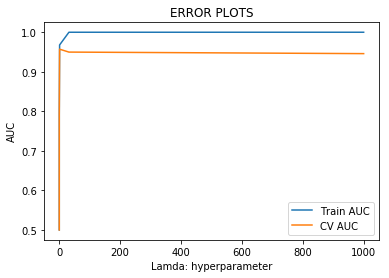

In [291]:
bestLamda_tfidf_l1, weight_tfidf_l1 = getOptimizedLamda(X_train_tfidf, Y_train, regularization='l1')

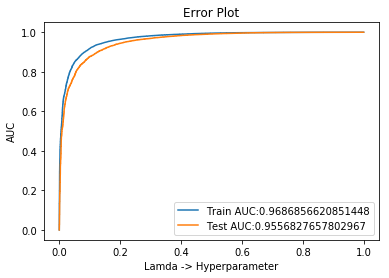

training confusion matrix
[[ 6936  3003]
 [  911 50591]]


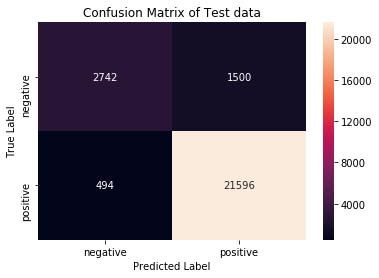

In [292]:
auc_tfidf_l1, classifier_tfidf_l1 = LR_test(X_train_tfidf, Y_train, X_test_tfidf, Y_test, bestLamda_tfidf_l1, 
                                            regularization = 'l1')

### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

Best Estimator:  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Best cross-validation score: 0.96
Best parameters:  1.0


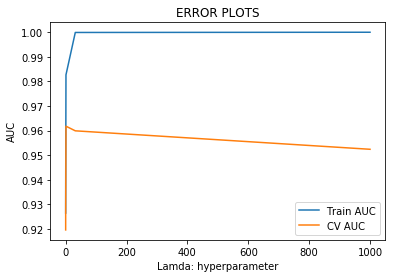

In [293]:
bestLamda_tfidf_l2, weight_tfidf_l2 = getOptimizedLamda(X_train_tfidf, Y_train, regularization='l2')

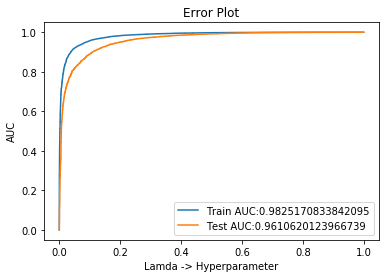

training confusion matrix
[[ 6854  3085]
 [  442 51060]]


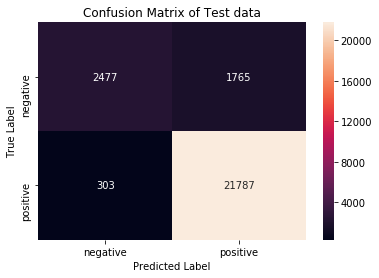

In [294]:
auc_tfidf_l2, classifier_tfidf_l2 = LR_test(X_train_tfidf, Y_train, X_test_tfidf, Y_test, bestLamda_tfidf_l2, 
                                            regularization = 'l2')

### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [295]:
positive_imp_features(tf_idf_vect,classifier_tfidf_l1)

Top ten positive features:
               Words       Coef
0  not disappointed  22.825052
1             great  19.626507
2         delicious  18.857224
3           perfect  15.811481
4              best  15.667930
5           amazing  13.506844
6             loves  13.127457
7         excellent  13.110314
8              good  12.962244
9         wonderful  11.628322


#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [296]:
negative_imp_features(tf_idf_vect,classifier_tfidf_l1)

Top ten negative predictors:
            Words       Coef
0      two stars  24.526229
1   disappointed  17.333876
2          worst  17.055447
3      not worth  15.598416
4  not recommend  13.147358
5          awful  12.820031
6       not good  11.921305
7       terrible  11.698929
8       horrible  11.669424
9  disappointing  11.433242


## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

Best Estimator:  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Best cross-validation score: 0.91
Best parameters:  1.0


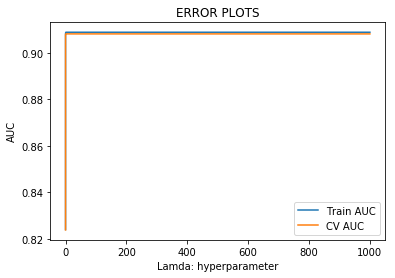

In [297]:
bestLamda_avgw2v_l1, weight_avgw2_l1 = getOptimizedLamda(sent_vectors_train, Y_train, regularization='l1')

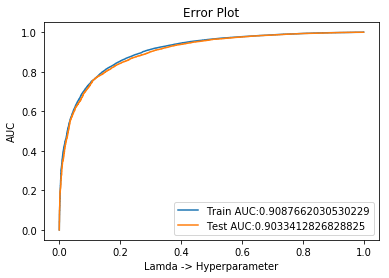

training confusion matrix
[[ 4908  5031]
 [ 1752 49750]]


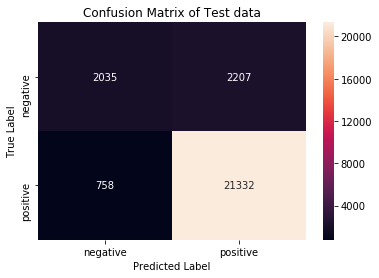

In [298]:
auc_avgw2v_l1, classifier_avgw2_l1 = LR_test(sent_vectors_train, Y_train, sent_vectors_test, Y_test, bestLamda_avgw2v_l1, 
                                            regularization = 'l1')

### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

Best Estimator:  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Best cross-validation score: 0.91
Best parameters:  1.0


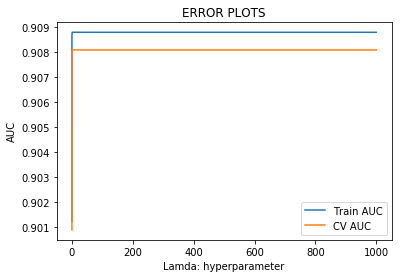

In [299]:
bestLamda_avgw2v_l2, weight_avgw2_l2 = getOptimizedLamda(sent_vectors_train, Y_train, regularization='l2')

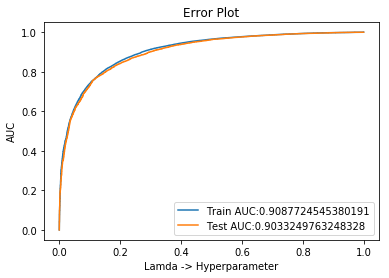

training confusion matrix
[[ 4909  5030]
 [ 1752 49750]]


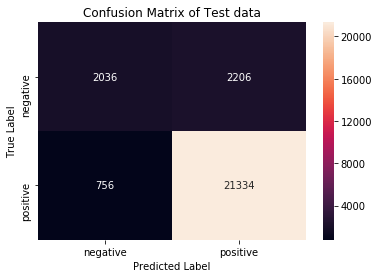

In [300]:
auc_avgw2_l2, classifier_avgw2_l2 = LR_test(sent_vectors_train, Y_train, sent_vectors_test, Y_test, bestLamda_avgw2v_l2, 
                                            regularization = 'l2')

## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

Best Estimator:  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Best cross-validation score: 0.89
Best parameters:  1.0


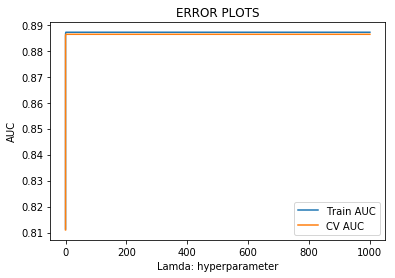

In [301]:
bestLamda_tfidfw2v_l1, weight_tfidfw2v_l1 = getOptimizedLamda(tfidf_sent_vectors_train, Y_train, regularization='l1')

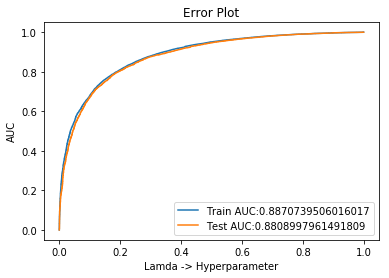

training confusion matrix
[[ 4134  5805]
 [ 1740 49762]]


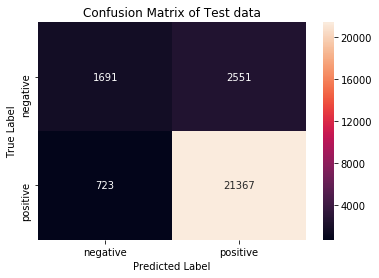

In [302]:
auc_tfidfw2v_l1, classifier_tfidfw2v_l1 = LR_test(tfidf_sent_vectors_train, Y_train, tfidf_sent_vectors_test, Y_test, 
                                            bestLamda_tfidfw2v_l1, regularization = 'l1')

### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

Best Estimator:  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Best cross-validation score: 0.89
Best parameters:  1.0


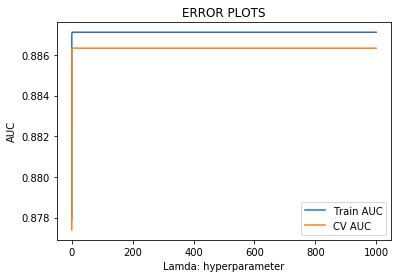

In [303]:
bestLamda_tfidfw2v_l2, weight_tfidfw2v_l2 = getOptimizedLamda(tfidf_sent_vectors_train, Y_train, regularization='l2')

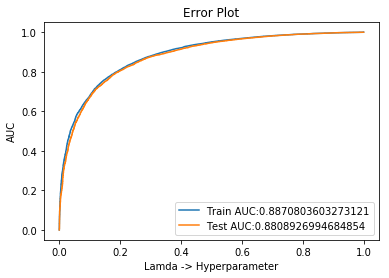

training confusion matrix
[[ 4139  5800]
 [ 1744 49758]]


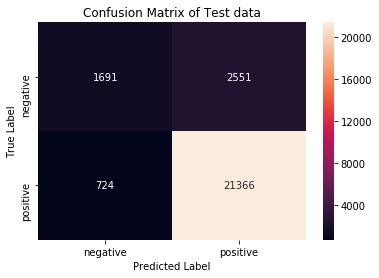

In [304]:
auc_tfidfw2v_l2, classifier_tfidfw2v_l2 = LR_test(tfidf_sent_vectors_train, Y_train, tfidf_sent_vectors_test, Y_test, 
                                            bestLamda_tfidfw2v_l2, regularization = 'l2')

# [6] Conclusions

In [305]:
models = pd.DataFrame({
'Vectorizer': ["BOW", "BOW", "TFIDF", "TFIDF",
               "AVGW2V", "AVGW2V", "TFIDFW2V", "TFIDFW2V"], 
'Model' : ['LogisticRegression', 'LogisticRegression', 'LogisticRegression', 'LogisticRegression', 
           'LogisticRegression', 'LogisticRegression', 'LogisticRegression', 'LogisticRegression'],
'Regulizer' : ['L1', 'L2','L1', 'L2',
               'L1', 'L2','L1', 'L2'],
'Hyper Parameter(Lamda)': [bestLamda_bow_l1, bestLamda_bow_l2, bestLamda_tfidf_l1, bestLamda_tfidf_l2,
                           bestLamda_avgw2v_l1,bestLamda_avgw2v_l2, bestLamda_tfidfw2v_l1, bestLamda_tfidfw2v_l2], 
'AUC': [auc_bow_l1, auc_bow_l2, auc_tfidf_l1, auc_tfidf_l2,
        auc_avgw2v_l1, auc_avgw2_l2, auc_tfidfw2v_l1, auc_tfidfw2v_l2]}, 
columns = ["Vectorizer", "Model", "Regulizer", "Hyper Parameter(Lamda)", "AUC"])
print(models)

  Vectorizer               Model Regulizer  Hyper Parameter(Lamda)       AUC
0        BOW  LogisticRegression        L1                   1.000  0.931836
1        BOW  LogisticRegression        L2                   0.032  0.936987
2      TFIDF  LogisticRegression        L1                   1.000  0.955683
3      TFIDF  LogisticRegression        L2                   1.000  0.961062
4     AVGW2V  LogisticRegression        L1                   1.000  0.903341
5     AVGW2V  LogisticRegression        L2                   1.000  0.903325
6   TFIDFW2V  LogisticRegression        L1                   1.000  0.880900
7   TFIDFW2V  LogisticRegression        L2                   1.000  0.880893


* BOW and TFIDF performs better than AVGW2V and TFIDFW2V